Imports and Configuration

In [4]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import LeakyReLU
import matplotlib.cm as cm
import matplotlib.colors as mcolors

# Paths
MODELS_FOLDER = "archive/models"
LOG_FILE = "archive/models_version_old.csv"
SIM_DATA_FILE = "archive/tmp.csv"
FIG_FOLDER = "archive/figures"
os.makedirs(FIG_FOLDER, exist_ok=True)

# Constants 
topX = 20


Load Simulated Data and Set Input Values

In [5]:
# Fixed parameter values
X_val = 0.0004
Y_val = 0.005
T_val = 333.15
c_KOH_val = 1000
W_mem_val = 6e-5

# Load simulated PV curve
sim_df = pd.read_csv(SIM_DATA_FILE)
E_sim = sim_df['E_cell'].values.reshape(-1, 1)
I_sim = sim_df['I_density'].values

# Full input matrix
X_full = np.column_stack([
    np.full_like(E_sim, X_val),
    np.full_like(E_sim, Y_val),
    np.full_like(E_sim, T_val),
    np.full_like(E_sim, c_KOH_val),
    np.full_like(E_sim, W_mem_val),
    E_sim.flatten()
])


Plot All Models vs Simulated

C:\Users\ebben\AppData\Local\Temp\ipykernel_32064\2816801682.py:9: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('viridis')  # Or 'plasma', 'coolwarm', etc.


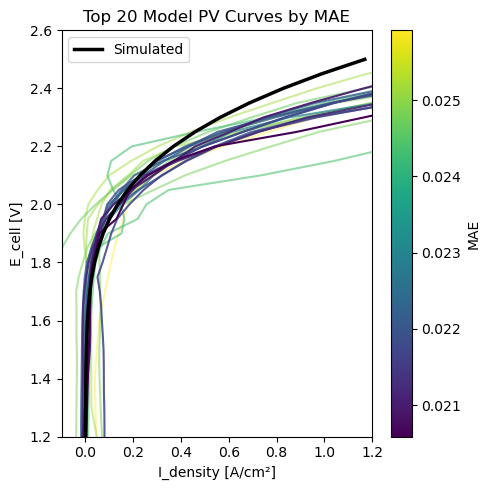

In [6]:
df_log = pd.read_csv(LOG_FILE)

# Sort by MAE and take top N models
top_df = df_log.sort_values(by='mae').head(topX).reset_index(drop=True)
mae_vals = top_df['mae'].values

# Normalize MAE values for color mapping
norm = mcolors.Normalize(vmin=mae_vals.min(), vmax=mae_vals.max())
cmap = cm.get_cmap('viridis')  # Or 'plasma', 'coolwarm', etc.


plt.figure(figsize=(5, 5))
plt.ylim(1.2, 2.6)
plt.xlim(-0.1, 1.2)

# Plot top N models with color and alpha encoding by MAE
for i, model_row in reversed(list(top_df.iterrows())):
    model_path = os.path.join(MODELS_FOLDER, model_row.model_name + ".keras")
    scaler_path = os.path.join(MODELS_FOLDER, model_row.model_name + "_scaler.pkl")

    if not os.path.exists(model_path) or not os.path.exists(scaler_path):
        continue

    model = load_model(model_path, custom_objects={"LeakyReLU": LeakyReLU})
    scaler = joblib.load(scaler_path)
    X_scaled = scaler.transform(X_full)
    I_pred = model.predict(X_scaled, verbose=False).flatten()

    color = cmap(norm(mae_vals[i]))
    alpha = 0.4 + 0.6 * (1 - norm(mae_vals[i]))  # alpha ∈ [0.4, 1.0]
    plt.plot(I_pred, E_sim.flatten(), color=color, alpha=alpha)

# Simulated curve
plt.plot(I_sim, E_sim.flatten(), color='black', linewidth=2.5, label='Simulated')

# Add colorbar for MAE
sm = cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])  # Dummy array
cbar = plt.colorbar(sm, ax=plt.gca())
cbar.set_label("MAE")


plt.title(f"Top {topX} Model PV Curves by MAE")
plt.xlabel("I_density [A/cm²]")
plt.ylabel("E_cell [V]")
plt.legend()
plt.tight_layout()
plt.savefig(os.path.join(FIG_FOLDER, f"topX_models_pv_curves.png"))
plt.show()


Best Models by Metric vs Simulated

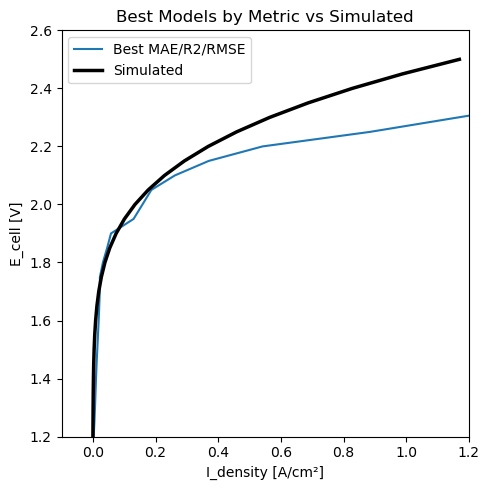

In [8]:
metrics = ['mae', 'r2', 'rmse']
colors = sns.color_palette("tab10", len(metrics))

plt.figure(figsize=(5, 5))
plt.ylim(1.2, 2.6)
plt.xlim(-0.1, 1.2)

seen_models = {}
color_idx = 0

for metric in metrics:
    ascending = metric != 'r2'
    best = df_log.sort_values(by=metric, ascending=ascending).iloc[0]
    model_name = best.model_name

    if model_name in seen_models:
        seen_models[model_name]['labels'].append(metric.upper())
        continue

    model_path = os.path.join(MODELS_FOLDER, model_name + ".keras")
    scaler_path = os.path.join(MODELS_FOLDER, model_name + "_scaler.pkl")
    model = load_model(model_path, custom_objects={"LeakyReLU": LeakyReLU})
    scaler = joblib.load(scaler_path)
    X_scaled = scaler.transform(X_full)
    I_pred = model.predict(X_scaled, verbose=False).flatten()

    seen_models[model_name] = {
        'I_pred': I_pred,
        'labels': [metric.upper()],
        'color': colors[color_idx % len(colors)]
    }
    color_idx += 1

# Plot unique models
for model_name, data in seen_models.items():
    label_str = f"Best {'/'.join(data['labels'])}"
    plt.plot(data['I_pred'], E_sim.flatten(), label=label_str, color=data['color'])

plt.plot(I_sim, E_sim.flatten(), color='black', linewidth=2.5, label='Simulated')
plt.title("Best Models by Metric vs Simulated")
plt.xlabel("I_density [A/cm²]")
plt.ylabel("E_cell [V]")
plt.legend()
# plt.grid(True)
plt.tight_layout()
plt.savefig(os.path.join(FIG_FOLDER, "best_models_by_metric.png"))
plt.show()


Bar Plot of Metrics

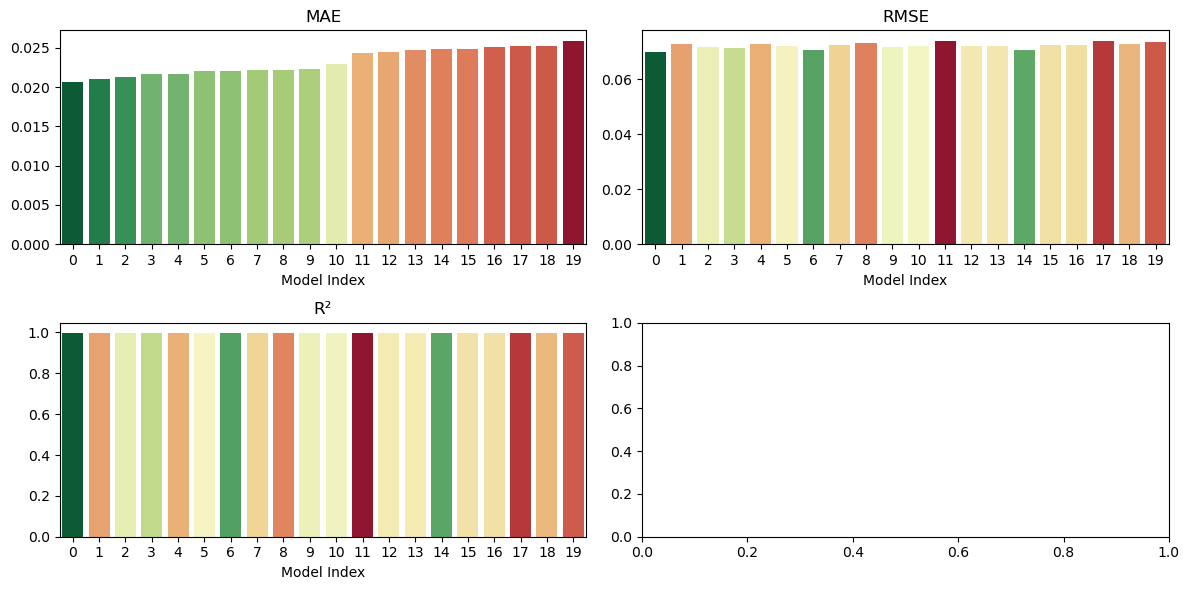

In [11]:
from matplotlib import colormaps
from matplotlib.colors import Normalize

plot_df = df_log[['model_name', 'mae', 'r2', 'rmse']].copy()
plot_df = plot_df.sort_values(by='mae').head(topX).reset_index(drop=True)

fig, axes = plt.subplots(2, 2, figsize=(12, 6))
metrics = ['mae', 'rmse', 'r2']
titles = ['MAE', 'RMSE', 'R²']
cmap_good_bad = colormaps["RdYlGn"]

for ax, metric, title in zip(axes.flatten(), metrics, titles):
    values = plot_df[metric].values

    reverse = metric != 'r2'
    norm = Normalize(vmin=values.min(), vmax=values.max())
    if reverse:
        colors = [cmap_good_bad(1 - norm(v)) for v in values]
    else:
        colors = [cmap_good_bad(norm(v)) for v in values]

    sns.barplot(x=plot_df.index, y=values, hue=plot_df.index, palette=colors, ax=ax, legend=False)
    ax.set_title(title)
    ax.set_xlabel('Model Index')
    ax.grid(False)

plt.tight_layout()
plt.savefig(os.path.join(FIG_FOLDER, "metric_bars_topX_models.png"))
plt.show()


In [ ]:
import pandas as pd
import numpy as np
import joblib
import tensorflow as tf
from os import path
from tensorflow.keras.models import load_model
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt

# Define paths and parameters
FOLDER_DATA = "data_comsol"
FILE_NAME = "2D_001.csv"
PATH_DATA = path.join(FOLDER_DATA, FILE_NAME)
SKIPROWS = 8

# Path to scaler and model
FOLDER_MODELS = "archive/models"
MODEL_NAME = "model_20250407_112922"

MODEL_PATH = path.join(FOLDER_MODELS, MODEL_NAME+".keras")
SCALER_PATH = path.join(FOLDER_MODELS, MODEL_NAME+"_scaler.pkl")

def plot_pv():

    
    # Path to the simulated data file (tmp.csv)
    SIM_DATA_PATH = "tmp.csv"
    
    # Load simulated COMSOL data (I_density in A/cm²)
    sim_df = pd.read_csv(SIM_DATA_PATH)
    # Expecting columns: 'E_cell' and 'I_density'
    
    # Load the saved model and scaler (using your existing paths)
    scaler = joblib.load(SCALER_PATH)
    model = load_model(MODEL_PATH)
    
    # Define fixed parameters for prediction
    w_mem = 0.00006         # Membrane thickness in m
    temp = 333.15           # Temperature in K
    c_KOH = 1000            # KOH concentration in mol/m^3
    # For the width (X): the left section is 0.00037m and the membrane is w_mem; use the right edge of the membrane
    x_val = 0.00037 + w_mem  # x = 0.00043 m
    y_val = 0.005           # Use the midpoint of the 0-0.01 m domain for Y
    
    # Generate a range of E_cell values covering the range in the simulated data
    E_cell_min = sim_df['E_cell'].min()
    E_cell_max = sim_df['E_cell'].max()
    E_cell_range = np.linspace(E_cell_min, E_cell_max, num=100)
    
    # Create the input feature array for each E_cell value
    # The order of features is: [X (m), Y (m), c_KOH (mol/m^3), W_mem (m), T (K), E_cell (V)]
    num_points = len(E_cell_range)
    X_model = np.column_stack((
        np.full(num_points, x_val),
        np.full(num_points, y_val),
        np.full(num_points, c_KOH),
        np.full(num_points, w_mem),
        np.full(num_points, temp),
        E_cell_range
    ))
    
    # Scale the input features using the saved scaler
    X_model_scaled = scaler.transform(X_model)
    
    # Predict I_density using the model (output is in A/m²)
    I_density_pred = model.predict(X_model_scaled).flatten()
    
    # Convert I_density from A/m² to A/cm² by dividing by 10,000
    I_density_pred_cm2 = I_density_pred / 10000.0
    
    # Plot the simulated PV curve and the model prediction on the same graph
    plt.figure(figsize=(8, 6))
    plt.plot(sim_df['E_cell'], sim_df['I_density'], label='Simulated (COMSOL)', marker='o', linestyle='-')
    plt.plot(E_cell_range, I_density_pred_cm2, label='Model Prediction', marker='x', linestyle='--')
    plt.xlabel("E_cell (V)")
    plt.ylabel("I_density (A/cm²)")
    plt.title("PV Curve Comparison")
    plt.legend()
    plt.show()

# To execute the function, simply call:
plot_pv()

    

def main():
    # Load and preprocess data
    df = pd.read_csv(PATH_DATA, skiprows=SKIPROWS)
    df.columns = ['X (m)', 'Y (m)', 'c_KOH (mol/m^3)', 'W_mem (m)', 'T (K)', 'E_cell (V)', 'I_density (A/m^2)']
    df = df.dropna(subset=['I_density (A/m^2)'])
    
    # Define inputs and target
    X = df[['X (m)', 'Y (m)', 'c_KOH (mol/m^3)', 'W_mem (m)', 'T (K)', 'E_cell (V)']].values
    y = df['I_density (A/m^2)'].values

    # Load the saved scaler and transform the data
    scaler = joblib.load(SCALER_PATH)
    X_scaled = scaler.transform(X)

    # Split the data (use same parameters as during training)
    X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

    # Load the saved model
    model = load_model(MODEL_PATH)

    # Evaluate the model on the test set
    test_loss, test_mae = model.evaluate(X_test, y_test, verbose=1)
    print(f"Test Loss (MSE): {test_loss}")
    print(f"Test MAE: {test_mae}")

    # Generate predictions on the test set
    y_pred = model.predict(X_test)

    # Compute additional metrics: RMSE and R² Score
    rmse = np.sqrt(np.mean((y_pred.flatten() - y_test) ** 2))
    r2 = r2_score(y_test, y_pred)
    print(f"Test RMSE: {rmse}")
    print(f"Test R^2 Score: {r2}")

if __name__ == "__main__":
    main()